<a href="https://colab.research.google.com/github/MengjieSHI/learning-based-sos-correction-us-pa/blob/main/sos_reconstruction_us_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# import current working path 
import os
os.chdir("drive/My Drive/us_sos") 
#!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.8.0

In [ ]:
from tensorflow.python.ops.math_ops import truediv
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import pyplot

import h5py
import os
from sklearn.preprocessing import MinMaxScaler
from scipy.io import savemat

os.environ["CUDA_VISIBLE_DEVICES"]="0"

def extract_signals(filename, signalName):
    """Extract the signals into a 4D float64 numpy array [index, y, x, depth] - [50, 128, 1024, 1]"""
    fData = h5py.File(filename, 'r')
    inData = fData.get(signalName)
    print(inData.shape[0], inData.shape[1], inData.shape[2])
    num_examples = inData.shape[0] # (number_examples, rows, cols)
    rows = inData.shape[1]
    cols = inData.shape[2]
    print('Data size of:'+signalName)
    print(num_examples, rows, cols)
    data = np.array(inData)
    data = data.reshape(num_examples, rows, cols, 1)
    return data


def encoder_block(l2=0,dropout=0):
    '''fully connected neural network encoder part.

        Args:
          l2 (float): L2 regularization strength
          dropout (float): Dropout rate

        Returns:
          (keras Model)
        '''
    ## Input
    input_layer = keras.Input(shape=(128, 1024, 1), name='input',dtype='float32') # 128*1024*1

    e0 = keras.layers.GaussianNoise(1)(input_layer)

    # strided and 3*15 conv
    e1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 15), strides=(1, 2), padding='same', activation='LeakyReLU',
                            kernel_initializer=keras.initializers.GlorotUniform(), name='encoder_conv1')(input_layer)
    e1 = keras.layers.BatchNormalization()(e1, training=True)
    # strided and 3*13 conv
    e2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 13), strides=(1, 2), padding='same', activation='LeakyReLU',
                             kernel_initializer=keras.initializers.GlorotUniform(), name='encoder_conv2')(e1)
    e2 = keras.layers.BatchNormalization()(e2, training=True)
    # strided and 3*11 conv
    e3 = keras.layers.Conv2D(filters=32, kernel_size=(3, 11), strides=(1, 2), padding='same', activation='LeakyReLU',
                            kernel_initializer=keras.initializers.GlorotUniform(), name='encoder_conv3')(e2)
    e3 = keras.layers.BatchNormalization()(e3, training=True)
    # strided and 3*9 conv
    e4 = keras.layers.Conv2D(filters=32, kernel_size=(3, 9), strides=(1, 2), padding='same', activation='LeakyReLU',
                            kernel_initializer=keras.initializers.GlorotUniform(), name='encoder_conv4')(e3)
    e4 = keras.layers.Dropout(rate=0.5, name='dropout4')(e4)
    e4 = keras.layers.BatchNormalization()(e4, training=True)

    # strided and 3*7 conv and maxpooling
    e5 = keras.layers.Conv2D(filters=64, kernel_size=(3, 7), strides=(1, 1), padding='same', activation='LeakyReLU',
                              kernel_initializer=keras.initializers.GlorotUniform(), name='encoder_conv5')(e4)
    e5 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='encoder_pool1')(e5)
    e5 = keras.layers.Dropout(rate=0.5, name='dropout5')(e5)
    e5 = keras.layers.BatchNormalization()(e5, training=True)
    # strided and 3*5 conv and maxpooling
    e6 = keras.layers.Conv2D(filters=128, kernel_size=(3, 5), strides=(1, 1), padding='same', activation='LeakyReLU',
                              kernel_initializer=keras.initializers.GlorotUniform(), name='encoder_conv6')(e5)
    e6 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='encoder_pool2')(e6)
    e6 = keras.layers.BatchNormalization()(e6, training=True)
    # strided and 3*3 conv and maxpooling
    e7 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='LeakyReLU',
                             kernel_initializer=keras.initializers.GlorotUniform(), name='encoder_conv7')(e6)
    e7 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='encoder_pool3')(e7)
    e7 = keras.layers.Dropout(rate=0.5, name='dropout7')(e7)
    #e7 = keras.layers.BatchNormalization()(e7, training=True)
    model = keras.Model(input_layer, e7)
    model.summary()

    return model

def decoder_block(encoder_block, l2=0):
    ''' upsampled FCN.

        Args:
          encoder_block (keras Model): encoder model to build upon
          l2 (float): L2 regularization strength

        Returns:
          (keras Model)
        '''
    # 3*3 conv + 2d interpolate
    d1 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='LeakyReLU',
                            kernel_initializer=keras.initializers.GlorotUniform(),
                            name='decoder_conv1')(encoder_block.get_layer('encoder_pool3').output)
    d2 = keras.layers.UpSampling2D(size=(2, 2),interpolation='bilinear')(d1)
    d2 = keras.layers.BatchNormalization()(d2, training=True) 
    # merge
    d3 = keras.layers.Concatenate()([encoder_block.get_layer('encoder_pool2').output, d2])

    # 3*5 conv + 2d interpolate
    d4 = keras.layers.Conv2D(filters=64, kernel_size=(3, 5), strides=(1, 1), padding='same', activation='LeakyReLU',
                             kernel_initializer=keras.initializers.GlorotUniform(),
                             name='decoder_conv2')(d3)
    d5 = keras.layers.UpSampling2D(size=(2, 2),interpolation='bilinear')(d4)
    d5 = keras.layers.BatchNormalization()(d5, training=True)
    d6 = keras.layers.Concatenate()([encoder_block.get_layer('encoder_pool1').output, d5])

    # 3*7 conv + 2d interpolate
    d7 = keras.layers.Conv2D(filters=32, kernel_size=(3, 7), strides=(1, 1), padding='same', activation='LeakyReLU',
                             kernel_initializer=keras.initializers.GlorotUniform(),
                             name ='decoder_conv3')(d6)
    d8 = keras.layers.UpSampling2D(size=(2, 2),interpolation='bilinear')(d7)
    d8 = keras.layers.BatchNormalization()(d8, training=True)
    d9 = keras.layers.Concatenate()([encoder_block.get_layer('encoder_conv4').output, d8])

    # 3* 9 conv + 2d interpolate
    d10 = keras.layers.Conv2D(filters=32, kernel_size=(3, 9), strides=(1, 1), padding='same', activation='LeakyReLU',
                              kernel_initializer=keras.initializers.GlorotUniform(),
                              name = 'decoder_conv4')(d9)
    d11 = keras.layers.UpSampling2D(size=(2, 2),interpolation='bilinear')(d10) # 32*128*256
    d11 = keras.layers.BatchNormalization()(d11, training=True)
    # conv. + interpolate + (bn)
    d12 = keras.layers.Conv2D(filters=32, kernel_size=(3, 11), strides=(1, 1), padding='same', activation='LeakyReLU',
                              kernel_initializer=keras.initializers.GlorotUniform(),
                              name='decoder_conv5')(d11)
    #d12 = keras.layers.UpSampling2D(size=(2,2))(d12) # 32*256*512        
    d13 = keras.layers.Resizing(384, 384, interpolation="bilinear", crop_to_aspect_ratio=False)(d12)
    #d13 = tf.image.resize(d12, [318, 318]) #
    d13 = keras.layers.BatchNormalization()(d13, training=True)
    #
    d14 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='LeakyReLU',
                              kernel_initializer=keras.initializers.GlorotUniform(),
                              name='decoder_conv6')(d13)
    d14 = keras.layers.BatchNormalization()(d14, training=True)
    # 1* 384*384
    d15 = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same',
                              kernel_initializer=keras.initializers.GlorotUniform(),
                              name='decoder_conv7')(d14)


    model = keras.Model(encoder_block.input, d15)
    opt = keras.optimizers.legacy.SGD(learning_rate=1e-5, decay=1e-5,momentum=0.9)
    loss_fn = keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
    
    model.compile(optimizer=opt, loss=tf.losses.mean_squared_error, metrics=keras.metrics.RootMeanSquaredError())
    model.summary()
    return model



In [ ]:
encoder_part = encoder_block(l2=1e-5, dropout=0.2)
built_model = decoder_block(encoder_part, l2=1e-5)

In [ ]:
# load dataset 
# load rf data 
data_input = extract_signals('us_simulated_rf_1511_1603_1_2_6000_training.mat','no_filtered_rf_norm_noisy')
# load sos maps 
data_target = extract_signals('us_simulated_rf_1511_1603_1_2_6000_training.mat','sos_map_d2').astype('uint16')



6000 128 1024
Data size of:no_filtered_rf_norm_noisy
6000 128 1024
6000 384 384
Data size of:sos_map_d2
6000 384 384


In [ ]:
# training 
history = built_model.fit(data_input, data_target, batch_size=10, epochs=100, verbose=1, validation_split=0.2,shuffle=True) # initial batch size 10 
built_model.save('savedmodel_nofil_lr1e-5_bs10_val0.2_dp0.5_ep100_Gnoise1_data15116000_model2703_1514.h5') 

Epoch 1/100
480/480 [==============================] - 116s 216ms/step - loss: 144248.5469 - root_mean_squared_error: 379.8009 - val_loss: 2138.4199 - val_root_mean_squared_error: 46.2431
Epoch 2/100
480/480 [==============================] - 101s 211ms/step - loss: 1624.6964 - root_mean_squared_error: 40.3075 - val_loss: 1664.2994 - val_root_mean_squared_error: 40.7958
Epoch 3/100
480/480 [==============================] - 101s 211ms/step - loss: 1343.4644 - root_mean_squared_error: 36.6533 - val_loss: 1376.1865 - val_root_mean_squared_error: 37.0970
Epoch 4/100
480/480 [==============================] - 101s 211ms/step - loss: 1220.9364 - root_mean_squared_error: 34.9419 - val_loss: 1260.3297 - val_root_mean_squared_error: 35.5011
Epoch 5/100
480/480 [==============================] - 101s 211ms/step - loss: 1128.2589 - root_mean_squared_error: 33.5896 - val_loss: 1108.6431 - val_root_mean_squared_error: 33.2963
Epoch 6/100
480/480 [==============================] - 101s 211ms/step -

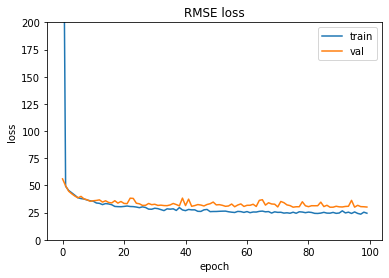

In [ ]:

pyplot.plot(history.history['root_mean_squared_error'])
pyplot.plot(history.history['val_root_mean_squared_error'])
pyplot.title('RMSE loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.ylim([0, 200])
pyplot.legend(['train', 'val'], loc='upper right')
pyplot.show()

In [ ]:
# visual the output
trained_model = keras.models.load_model('./savedmodel_nofil_lr1e-5_bs10_val0.1_dp0.5_ep100_Gnoise1_data15116000_model2703_1055.h5')

predicted_output_valid = trained_model.predict_on_batch(data_input[1000:1020,:,:,:])
predicted_output_train = trained_model.predict_on_batch(data_input[0:20,:,:,:])


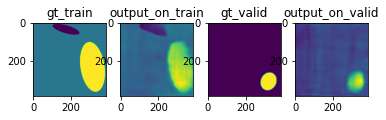

In [ ]:
# data 
n_img =3;
pyplot.subplot(1,4,1)
pyplot.imshow(tf.squeeze(data_target[n_img,:,:,:].round()))
pyplot.title('gt_train')
pyplot.subplot(1,4,2)
pyplot.imshow(tf.squeeze(predicted_output_train[n_img,:,:,:].round()))
pyplot.title('output_on_train')
pyplot.subplot(1,4,3)
pyplot.imshow(tf.squeeze(data_target[n_img+1000,:,:,:]))
pyplot.title('gt_valid')
pyplot.subplot(1,4,4)
pyplot.imshow(tf.squeeze(predicted_output_valid[n_img,:,:,:]))
pyplot.title('output_on_valid')
pyplot.show()


#savemat('validate_data16031511.mat',{'input':data_input[0:10,:,:,:],'output':predicted_output_train,'target':data_target[0:10,:,:]})